In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from utils import print_metrics, train_model, count_parameters
import timm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# use data augmentation
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(10),
    torchvision.transforms.ToTensor()
])
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])
# load CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=test_transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
# create data loaders
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
train_dataset.dataset.transform = train_transform
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


Number of trainable parameters: 20490
Epoch: 1/15 	 Train loss: 2.202 	 Train accuracy: 0.230 	 val loss: 2.259 	 val accuracy: 0.322
Epoch: 2/15 	 Train loss: 2.068 	 Train accuracy: 0.327 	 val loss: 2.243 	 val accuracy: 0.368
Epoch: 3/15 	 Train loss: 1.989 	 Train accuracy: 0.353 	 val loss: 2.068 	 val accuracy: 0.386
Epoch: 4/15 	 Train loss: 1.940 	 Train accuracy: 0.363 	 val loss: 2.014 	 val accuracy: 0.401
Epoch: 5/15 	 Train loss: 1.902 	 Train accuracy: 0.374 	 val loss: 2.539 	 val accuracy: 0.395
Epoch: 6/15 	 Train loss: 1.874 	 Train accuracy: 0.377 	 val loss: 1.923 	 val accuracy: 0.398
Epoch: 7/15 	 Train loss: 1.847 	 Train accuracy: 0.383 	 val loss: 2.141 	 val accuracy: 0.412
Epoch: 8/15 	 Train loss: 1.834 	 Train accuracy: 0.385 	 val loss: 1.822 	 val accuracy: 0.414
Epoch: 9/15 	 Train loss: 1.813 	 Train accuracy: 0.390 	 val loss: 1.778 	 val accuracy: 0.409
Epoch: 10/15 	 Train loss: 1.802 	 Train accuracy: 0.393 	 val loss: 1.873 	 val accuracy: 0.430
E

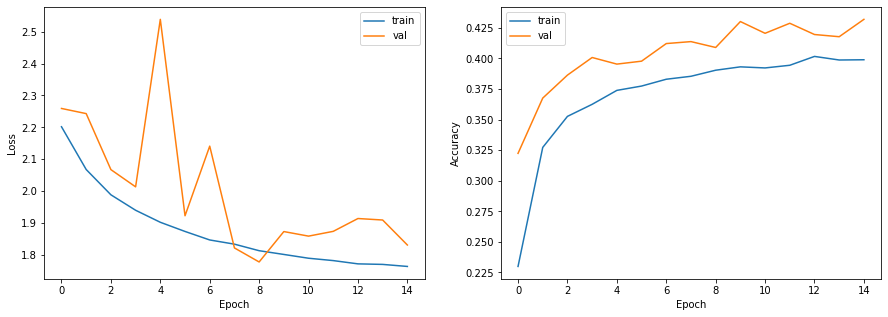

In [6]:
# load ResNet50 model using timm
model = timm.create_model('resnet50', pretrained=True)
# change the last layer to 10 classes
model.fc = nn.Linear(2048, 10)
# freeze all layers except the last layer
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True
# move model to GPU
model = model.to(device)

# define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
print("Number of trainable parameters: {}".format(count_parameters(model)))
# use train_model function to train the model
train_losses, val_losses, train_acc, val_acc = train_model(model, train_loader, val_loader, epochs=15, criterion=criterion, optimizer=optimizer, device=device)
# plot the training and validation loss and accuracy
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

              precision    recall  f1-score   support

    airplane       0.46      0.48      0.47      1000
  automobile       0.55      0.53      0.54      1000
        bird       0.34      0.43      0.38      1000
         cat       0.39      0.32      0.35      1000
        deer       0.42      0.35      0.38      1000
         dog       0.43      0.43      0.43      1000
        frog       0.50      0.53      0.51      1000
       horse       0.40      0.49      0.44      1000
        ship       0.49      0.47      0.48      1000
       truck       0.55      0.46      0.50      1000

    accuracy                           0.45     10000
   macro avg       0.45      0.45      0.45     10000
weighted avg       0.45      0.45      0.45     10000



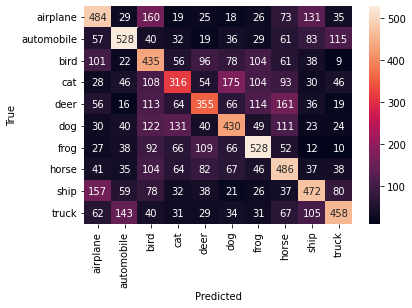

In [7]:
 # test the model on test data
print_metrics(model, test_loader, classes=test_dataset.classes, device=device)

In [8]:
# load ResNet18 model
student_model = timm.create_model('resnet18', pretrained=True)
# change the last layer to 10 classes
student_model.fc = nn.Linear(512, 10)
# move model to GPU
student_model = student_model.to(device)

# define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(student_model.parameters(), lr=1e-4)

In [9]:
# define a function to find the best alpha and T
def find_best_alpha_T(student_model, teacher_model, train_loader, test_loader, criterion, optimizer, epochs=10, T_list=[1, 10, 100], alpha_list=[0.1, 0.5, 0.9]):
    best_acc = 0
    best_alpha = 0
    best_T = 0
    for T in T_list:
        for alpha in alpha_list:
            print(f'alpha={alpha}, T={T}')
            student_model = timm.create_model('resnet18', pretrained=True)
            student_model.fc = nn.Linear(512, 10)
            student_model = student_model.to(device)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(student_model.parameters(), lr=1e-4)
            train_loss, test_loss, train_acc, test_acc = train_model(student_model, train_loader, test_loader, epochs=epochs, criterion=criterion, optimizer=optimizer, device=device, teacher_model=model, T=T, alpha=alpha)
            if test_acc[-1] > best_acc:
                best_acc = test_acc[-1]
                best_alpha = alpha
                best_T = T
    return best_acc, best_alpha, best_T


In [10]:
# find the best alpha and T
best_acc, best_alpha, best_T = find_best_alpha_T(student_model, model, train_loader, val_loader, criterion, optimizer, epochs=4, T_list=[1, 10, 20], alpha_list=[0.1, 0.5, 0.9])

alpha=0.1, T=1
Epoch: 1/4 	 Train loss: 2.085 	 Train accuracy: 0.505 	 val loss: 2.042 	 val accuracy: 0.613
Epoch: 2/4 	 Train loss: 2.038 	 Train accuracy: 0.611 	 val loss: 2.022 	 val accuracy: 0.644
Epoch: 3/4 	 Train loss: 2.028 	 Train accuracy: 0.634 	 val loss: 2.021 	 val accuracy: 0.662
Epoch: 4/4 	 Train loss: 2.021 	 Train accuracy: 0.648 	 val loss: 2.020 	 val accuracy: 0.669
alpha=0.5, T=1
Epoch: 1/4 	 Train loss: 1.801 	 Train accuracy: 0.578 	 val loss: 1.668 	 val accuracy: 0.710
Epoch: 2/4 	 Train loss: 1.657 	 Train accuracy: 0.719 	 val loss: 1.622 	 val accuracy: 0.759
Epoch: 3/4 	 Train loss: 1.623 	 Train accuracy: 0.763 	 val loss: 1.597 	 val accuracy: 0.783
Epoch: 4/4 	 Train loss: 1.597 	 Train accuracy: 0.794 	 val loss: 1.594 	 val accuracy: 0.794
alpha=0.9, T=1
Epoch: 1/4 	 Train loss: 1.315 	 Train accuracy: 0.600 	 val loss: 1.026 	 val accuracy: 0.731
Epoch: 2/4 	 Train loss: 1.010 	 Train accuracy: 0.737 	 val loss: 0.939 	 val accuracy: 0.765
Epoch

In [13]:
best_T, best_alpha = 10, 0.9 # From multiple experiments
print(f"Best T={best_T}, best alpha={best_alpha}")

Best T=10, best alpha=0.9


In [14]:
# train the student model with the best alpha and T
student_model = timm.create_model('resnet18', pretrained=True)
student_model.fc = nn.Linear(512, 10)
student_model = student_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(student_model.parameters(), lr=1e-4)
train_loss, test_loss, train_acc, test_acc = train_model(student_model, train_loader, val_loader, epochs=15, criterion=criterion, optimizer=optimizer, device=device, teacher_model=model, T=10, alpha=best_alpha)

Epoch: 1/15 	 Train loss: 24.078 	 Train accuracy: 0.601 	 val loss: 23.758 	 val accuracy: 0.730
Epoch: 2/15 	 Train loss: 23.757 	 Train accuracy: 0.738 	 val loss: 23.665 	 val accuracy: 0.776
Epoch: 3/15 	 Train loss: 23.655 	 Train accuracy: 0.779 	 val loss: 23.627 	 val accuracy: 0.786
Epoch: 4/15 	 Train loss: 23.589 	 Train accuracy: 0.809 	 val loss: 23.587 	 val accuracy: 0.810
Epoch: 5/15 	 Train loss: 23.537 	 Train accuracy: 0.827 	 val loss: 23.574 	 val accuracy: 0.809
Epoch: 6/15 	 Train loss: 23.500 	 Train accuracy: 0.844 	 val loss: 23.567 	 val accuracy: 0.819
Epoch: 7/15 	 Train loss: 23.465 	 Train accuracy: 0.858 	 val loss: 23.530 	 val accuracy: 0.830
Epoch: 8/15 	 Train loss: 23.440 	 Train accuracy: 0.868 	 val loss: 23.536 	 val accuracy: 0.827
Epoch: 9/15 	 Train loss: 23.407 	 Train accuracy: 0.880 	 val loss: 23.545 	 val accuracy: 0.829
Epoch: 10/15 	 Train loss: 23.388 	 Train accuracy: 0.889 	 val loss: 23.536 	 val accuracy: 0.835
Epoch: 11/15 	 Trai

              precision    recall  f1-score   support

    airplane       0.88      0.84      0.86      1000
  automobile       0.92      0.89      0.90      1000
        bird       0.77      0.81      0.79      1000
         cat       0.68      0.71      0.69      1000
        deer       0.84      0.82      0.83      1000
         dog       0.76      0.73      0.75      1000
        frog       0.91      0.88      0.89      1000
       horse       0.89      0.89      0.89      1000
        ship       0.90      0.92      0.91      1000
       truck       0.87      0.90      0.89      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



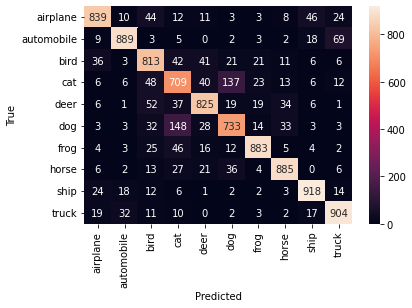

Number of trainable parameters: 11181642


In [15]:
# test the student model on test data
print_metrics(student_model, test_loader, classes=test_dataset.classes, device=device)
print(f'Number of trainable parameters: {count_parameters(student_model)}')

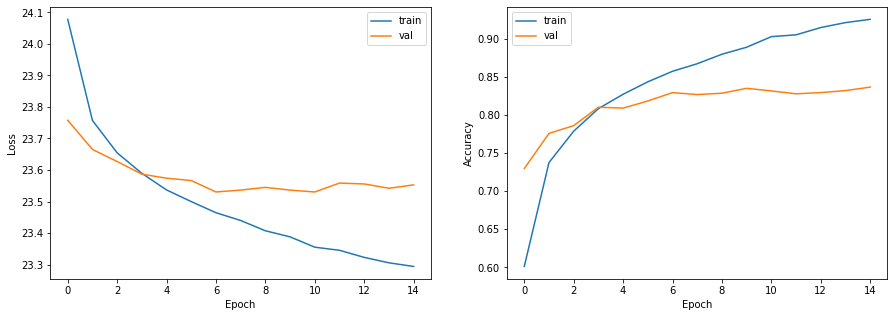

In [16]:
# plot the training and validation loss and accuracy
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [17]:
# fine-tune all of resnet18 model
model = timm.create_model('resnet18', pretrained=True)
model.fc = nn.Linear(512, 10)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
train_loss, test_loss, train_acc, test_acc = train_model(model, train_loader, val_loader, epochs=15, criterion=criterion, optimizer=optimizer, device=device)

Epoch: 1/15 	 Train loss: 1.138 	 Train accuracy: 0.604 	 val loss: 0.794 	 val accuracy: 0.723
Epoch: 2/15 	 Train loss: 0.756 	 Train accuracy: 0.737 	 val loss: 0.640 	 val accuracy: 0.770
Epoch: 3/15 	 Train loss: 0.638 	 Train accuracy: 0.781 	 val loss: 0.620 	 val accuracy: 0.785
Epoch: 4/15 	 Train loss: 0.563 	 Train accuracy: 0.805 	 val loss: 0.582 	 val accuracy: 0.796
Epoch: 5/15 	 Train loss: 0.497 	 Train accuracy: 0.828 	 val loss: 0.567 	 val accuracy: 0.814
Epoch: 6/15 	 Train loss: 0.451 	 Train accuracy: 0.844 	 val loss: 0.559 	 val accuracy: 0.816
Epoch: 7/15 	 Train loss: 0.411 	 Train accuracy: 0.855 	 val loss: 0.551 	 val accuracy: 0.814
Epoch: 8/15 	 Train loss: 0.369 	 Train accuracy: 0.870 	 val loss: 0.532 	 val accuracy: 0.820
Epoch: 9/15 	 Train loss: 0.339 	 Train accuracy: 0.882 	 val loss: 0.539 	 val accuracy: 0.823
Epoch: 10/15 	 Train loss: 0.316 	 Train accuracy: 0.891 	 val loss: 0.534 	 val accuracy: 0.832
Epoch: 11/15 	 Train loss: 0.290 	 Trai

              precision    recall  f1-score   support

    airplane       0.86      0.85      0.86      1000
  automobile       0.91      0.89      0.90      1000
        bird       0.81      0.81      0.81      1000
         cat       0.69      0.68      0.69      1000
        deer       0.81      0.85      0.83      1000
         dog       0.78      0.73      0.75      1000
        frog       0.89      0.88      0.88      1000
       horse       0.88      0.89      0.89      1000
        ship       0.92      0.89      0.90      1000
       truck       0.85      0.92      0.88      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



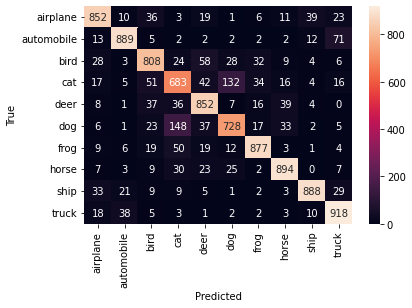

Number of trainable parameters: 11181642


In [18]:
# test the student model on test data
print_metrics(model, test_loader, classes=test_dataset.classes, device=device)
print(f'Number of trainable parameters: {count_parameters(student_model)}')

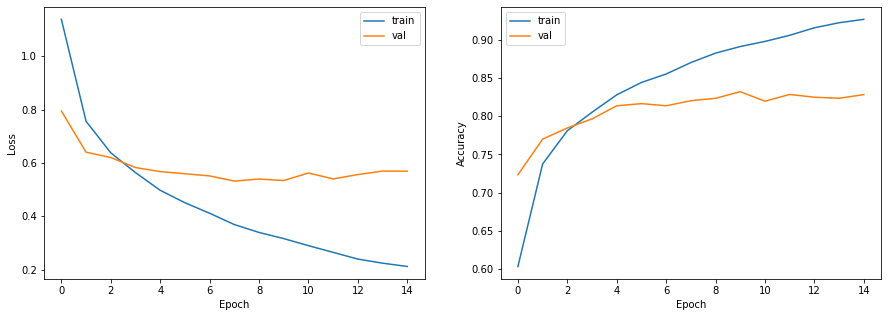

In [19]:
# plot the training and validation loss and accuracy
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [20]:
# fine-tune all of resnet50 model
model = timm.create_model('resnet50', pretrained=True)
model.fc = nn.Linear(2048, 10)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
train_loss, test_loss, train_acc, test_acc = train_model(model, train_loader, val_loader, epochs=15, criterion=criterion, optimizer=optimizer, device=device)


Epoch: 1/15 	 Train loss: 2.018 	 Train accuracy: 0.298 	 val loss: 1.646 	 val accuracy: 0.461
Epoch: 2/15 	 Train loss: 1.411 	 Train accuracy: 0.515 	 val loss: 1.178 	 val accuracy: 0.587
Epoch: 3/15 	 Train loss: 1.127 	 Train accuracy: 0.607 	 val loss: 1.086 	 val accuracy: 0.652
Epoch: 4/15 	 Train loss: 0.978 	 Train accuracy: 0.656 	 val loss: 0.938 	 val accuracy: 0.691
Epoch: 5/15 	 Train loss: 0.869 	 Train accuracy: 0.699 	 val loss: 0.808 	 val accuracy: 0.721
Epoch: 6/15 	 Train loss: 0.794 	 Train accuracy: 0.726 	 val loss: 0.754 	 val accuracy: 0.743
Epoch: 7/15 	 Train loss: 0.731 	 Train accuracy: 0.744 	 val loss: 0.716 	 val accuracy: 0.756
Epoch: 8/15 	 Train loss: 0.685 	 Train accuracy: 0.763 	 val loss: 0.761 	 val accuracy: 0.766
Epoch: 9/15 	 Train loss: 0.638 	 Train accuracy: 0.778 	 val loss: 0.641 	 val accuracy: 0.788
Epoch: 10/15 	 Train loss: 0.598 	 Train accuracy: 0.791 	 val loss: 0.635 	 val accuracy: 0.795
Epoch: 11/15 	 Train loss: 0.562 	 Trai

              precision    recall  f1-score   support

    airplane       0.88      0.85      0.87      1000
  automobile       0.91      0.89      0.90      1000
        bird       0.81      0.77      0.79      1000
         cat       0.67      0.69      0.68      1000
        deer       0.84      0.77      0.80      1000
         dog       0.69      0.73      0.71      1000
        frog       0.85      0.90      0.87      1000
       horse       0.86      0.84      0.85      1000
        ship       0.89      0.92      0.90      1000
       truck       0.88      0.88      0.88      1000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



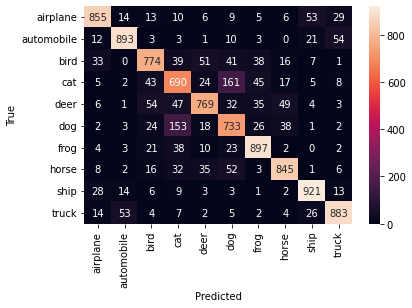

Number of trainable parameters: 11181642


In [21]:
# test the student model on test data
print_metrics(model, test_loader, classes=test_dataset.classes, device=device)
print(f'Number of trainable parameters: {count_parameters(student_model)}')

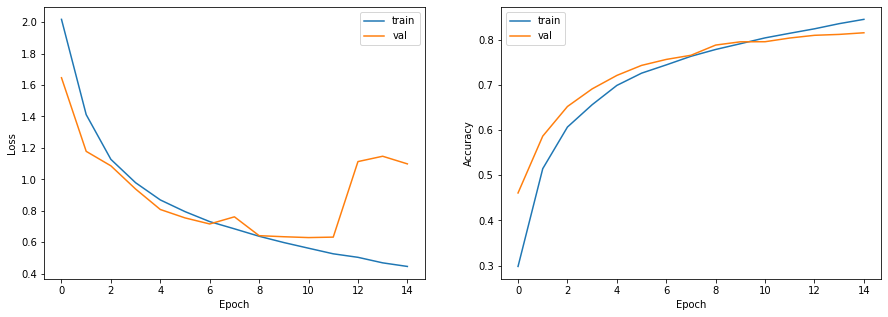

In [22]:
# plot the training and validation loss and accuracy
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()